<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_18/s18_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo


Cloning into 'ERA_V1'...
remote: Enumerating objects: 1505, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 1505 (delta 36), reused 32 (delta 5), pack-reused 1407
Receiving objects: 100% (1505/1505), 201.95 MiB | 26.51 MiB/s, done.
Resolving deltas: 100% (728/728), done.
fatal: not a git repository (or any of the parent directories): .git


In [2]:
import sys
sys.path.append("ERA_V1/session_18")


Add all the imports:

In [3]:
from __future__ import print_function
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from unet_model import UNet
from data_loader import load_oxford_pet_data

Allocate GPU and print model summary

In [8]:
import torch
import torch.nn as nn


class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ContractingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        skip = x  # store the output for the skip connection
        x = self.maxpool(x)
        return x, skip


class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ExpandingBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

        self.upsample = nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)

    def forward(self, x, skip):
        #print("x: ", x.shape)
        #print("skip: ", skip.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.upsample(x)

        # concatenate the skip connection
        x = torch.cat((x, skip), dim=1)

        return x


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        self.contract1 = ContractingBlock(in_channels, 64)
        self.contract2 = ContractingBlock(64, 128)
        self.contract3 = ContractingBlock(128, 256)
        self.contract4 = ContractingBlock(256, 512)
        self.bottle_neck = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        self.upsample = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.expand1 = ExpandingBlock(1024, 512)
        self.expand2 = ExpandingBlock(512, 256)
        self.expand3 = ExpandingBlock(256, 128)

        self.final_dim_reduction = nn.Sequential(*[nn.Conv2d(128, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(64, 64, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True),
                                          nn.Conv2d(64,2, kernel_size=3, padding=1),
                                          nn.ReLU(inplace=True)])
        self.final_block = nn.Conv2d(2, 1, kernel_size=1)



    def forward(self, x):
        # Contracting path
        x, skip1 = self.contract1(x)
        #print("first contract block:", x.shape, skip1.shape)
        x, skip2 = self.contract2(x)
        #print("second contract block:", x.shape, skip2.shape)
        x, skip3 = self.contract3(x)
        #print("third contract block:", x.shape, skip3.shape)
        x, skip4 = self.contract4(x)
        #print("fourth contract block:", x.shape, skip4.shape)
        x = self.bottle_neck(x)
        #print("bottle neck:", x.shape)
        x = self.upsample(x)
        #print("upsample:", x.shape)
        x = torch.cat((x, skip4), dim=1)
        #print("cat:", x.shape)

        # Expanding path
        #print("-------------")
        #print("starting expand block:", x.shape)
        x3 = self.expand1(x, skip3)
        #print("after first expand block:", x3.shape)
        x2 = self.expand2(x3, skip2)
        #print("after second expand block:", x2.shape)
        x1 = self.expand3(x2, skip1)
        #print("after third expand block:", x1.shape)
        #x1 = self.expand4(x2, skip1)

        x  = self.final_dim_reduction(x1)
        #print("after final dim reduction:", x.shape)
        x_out = self.final_block(x)
        #print("after 1 x 1:", x_out.shape)
        return x_out


In [9]:
def model_summary(model, input_size):
    summary(model, input_size = input_size)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
unet_model = UNet(in_channels=3,out_channels=1).to(device)
model_summary(unet_model, input_size=(3,48,48))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
            Conv2d-4           [-1, 64, 48, 48]          36,928
       BatchNorm2d-5           [-1, 64, 48, 48]             128
              ReLU-6           [-1, 64, 48, 48]               0
         MaxPool2d-7           [-1, 64, 24, 24]               0
  ContractingBlock-8  [[-1, 64, 24, 24], [-1, 64, 48, 48]]               0
            Conv2d-9          [-1, 128, 24, 24]          73,856
      BatchNorm2d-10          [-1, 128, 24, 24]             256
             ReLU-11          [-1, 128, 24, 24]               0
           Conv2d-12          [-1, 128, 24, 24]         147,584
      BatchNorm2d-13          [-1, 128, 24, 24]             256
             ReLU-14        

Define Albumentations image augmentations. We use RandomResizedCrop, HorizontalFlip, and cutout

In [11]:
import numpy as np
from typing import Any
from torchvision import datasets, transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

def oxford_transforms(image, mask):
    # Resize
    resize = transforms.Resize(size=(48, 48))
    image = resize(image)
    mask = resize(mask)

    # Transform to tensor
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    mask = to_tensor(mask)
    return image, mask

class OxfordPetDataset(Dataset):

    def __init__(self, dataset, transforms=None):
        self.transforms = transforms
        self.dataset = dataset


    def __len__(self) -> int:
        return len(self.dataset)


    def __getitem__(self, index) -> Any:
        image, label = self.dataset[index]
        image = np.array(image)
        if self.transforms is not None:
            image = self.transforms(image)
        return (image, label)


def load_oxford_pet_data(train_transforms, test_transforms, batch_size, **kwargs):
    train_data = datasets.OxfordIIITPet('../data', split='trainval', transforms = train_transforms, target_transform = None, target_types='segmentation', download=True)
    test_data = datasets.OxfordIIITPet('../data', split='test', transforms = test_transforms, target_transform = None, target_types='segmentation', download=True)

    train_loader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              **kwargs)
    test_loader = DataLoader(test_data,
                             batch_size=batch_size,
                             shuffle=True,
                             **kwargs)
    return train_loader, test_loader




Define batch size, train and test loaders

In [12]:
torch.manual_seed(1)
batch_size = 32
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader = load_oxford_pet_data(train_transforms=oxford_transforms, test_transforms=oxford_transforms, batch_size=batch_size, **kwargs)

100%|██████████| 791918971/791918971 [00:38<00:00, 20765775.82it/s]


Extracting ../data/oxford-iiit-pet/images.tar.gz to ../data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 11485164.09it/s]


Extracting ../data/oxford-iiit-pet/annotations.tar.gz to ../data/oxford-iiit-pet


In [13]:
a,b = next(iter(train_loader))
print(a.shape)
print(b.shape)

torch.Size([32, 3, 48, 48])
torch.Size([32, 1, 48, 48])


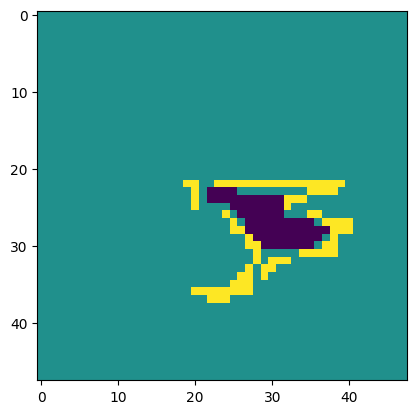

(48, 48, 3)


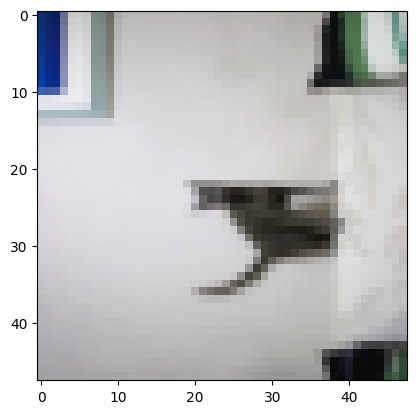

In [14]:
idx=10
c = np.asarray(b[idx]).transpose()
a1 = np.asarray(a[idx]).squeeze().transpose()
import matplotlib.pyplot as plt
plt.imshow(c.squeeze())
plt.show()
plt.figure()

print(a1.shape)
plt.imshow(a1)
plt.show()

Train model using Batch Normalization

In [19]:
from tqdm import tqdm

def model_train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        print(loss)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        correct+= output.argmax(dim=1).eq(target).sum().item()
        processed+= len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy = {100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return  loss.item()


In [21]:
num_epochs=24
unet_model = UNet(in_channels=3,out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(unet_model.parameters())


RuntimeError: ignored

In [18]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []

for epoch in range(1,num_epochs+1):
    print(f"epoch: {epoch}")
    this_train_loss = model_train(unet_model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    #this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



epoch: 1


loss=0.48013442754745483 batch_id=2 Accuracy = 0.00:   3%|▎         | 3/115 [00:01<01:11,  1.57it/s]


RuntimeError: ignored

Plot LR values

In [ ]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

In [ ]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [ ]:
print_train_log(train_acc, test_acc, train_losses, test_losses)